In [1]:
import sys
sys.path
sys.path.append('/home/nishadgothoskar/bayes3d')

In [4]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
# from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax
import bayes3d.genjax
import bayes3d.scene_graph

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


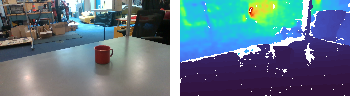

In [130]:
# files = glob.glob("./09-12-2023*.pkl")
# # all_data = pickle.load(open("tutorial_real_data.pkl", "rb"))
# file = files[4]
# print(file)
file = "./tutorial_mug_image.pkl"
all_data = pickle.load(open(file, "rb"))
IDX = 0
data = all_data[IDX]
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,1.0))

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

b.hstack_images([b.get_rgb_image(rgbd_scaled_down.rgb), b.get_depth_image(rgbd_scaled_down.depth)])

In [131]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
    jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

In [132]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
# b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
# b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


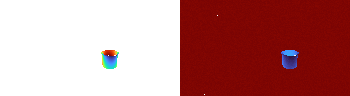

In [344]:
from dataclasses import dataclass

import jax
import jax.numpy as jnp
from genjax.core.datatypes import JAXGenerativeFunction
from genjax.generative_functions.distributions import ExactDensity


@dataclass
class ImageLikelihood(ExactDensity, JAXGenerativeFunction):
    def sample(self, key, rendered_img, radius):
        return rendered_img + jax.random.uniform(key, minval=-radius, maxval=radius, shape=rendered_img.shape)

    def logpdf(self, observed_image, rendered_img, radius):
        return b.threedp3_likelihood(
            observed_image,
            rendered_img,
            radius,
            0.0001,
        )
image_likelihood = ImageLikelihood()

@genjax.static
def full_model(table_pose, box_dims):
    contact = genjax.uniform(
        jnp.array([-0.5, -0.5, -10*jnp.pi]),
        jnp.array([0.5, 0.5, 10*jnp.pi])
    ) @ "contact"
    object_pose = table_pose @ b.scene_graph.relative_pose_from_edge(
        contact,
        3,
        box_dims
    )
    rendered_image = b.RENDERER.render(object_pose[None,...], jnp.array([0]))[..., :3]
    
    radius = genjax.uniform(0.001, 0.03) @ "radius"

    observed_xyz = image_likelihood(
        rendered_image,
        radius
    ) @ "observed_xyz"
    return observed_xyz, rendered_image, radius, contact

key = jax.random.PRNGKey(20)
trace = full_model.simulate(key, (table_pose, b.RENDERER.model_box_dims[0]))
b.hstack_images(
    [
        b.get_depth_image(trace.get_retval()[1][...,2]),
        b.get_depth_image(trace.get_retval()[0][...,2])
    ]
)

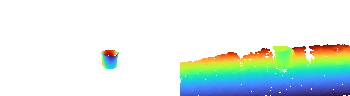

In [345]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
trace = trace.update(key, 
             genjax.choice_map({"observed_xyz": obs_img}), genjax.incremental.tree_diff_no_change(trace.get_args()))[0]
b.hstack_images(
    [
        b.get_depth_image(trace.get_retval()[1][...,2]),
        b.get_depth_image(trace.get_retval()[0][...,2])
    ]
)

In [346]:
def viz_trace(trace):
    b.clear_visualizer()
    b.show_cloud("obs", trace.get_retval()[0].reshape(-1,3),color=b.BLACK)
    b.show_cloud("latent", trace.get_retval()[1].reshape(-1,3),color=b.RED)
viz_trace(trace)

In [347]:
def update_trace(trace, cp):
    new_trace = trace.update(key, 
             genjax.choice_map({"contact": cp}), genjax.incremental.tree_diff_no_change(trace.get_args()))[0]
    return new_trace

def score_new_cp(trace, cp):
    new_trace = update_trace(trace, cp)
    return new_trace.get_score()
score_new_cp_vmap = jax.jit(jax.vmap(score_new_cp, in_axes=(None,0)))

In [348]:
def enumerate(min_x, max_x, min_y, max_y, min_z, max_z, num_x, num_y, num_z):   
    deltas = jnp.stack(
        jnp.meshgrid(
            jnp.linspace(min_x, max_x, num_x),
            jnp.linspace(min_y, max_y, num_y),
            jnp.linspace(min_z, max_z, num_z),
        ),
        axis=-1,
    )
    deltas = deltas.reshape(-1, 3)
    return deltas
cp_grid = enumerate(-0.3, 0.3, -0.3, 0.3, -jnp.pi, jnp.pi, 15, 15, 25)

scores = score_new_cp_vmap(trace, cp_grid)
print(scores.min(), scores.max())

new_trace = update_trace(trace, cp_grid[scores.argmax()])
print(new_trace.get_score())
viz_trace(new_trace)

trace = new_trace

214.36064 219.13974
219.13974


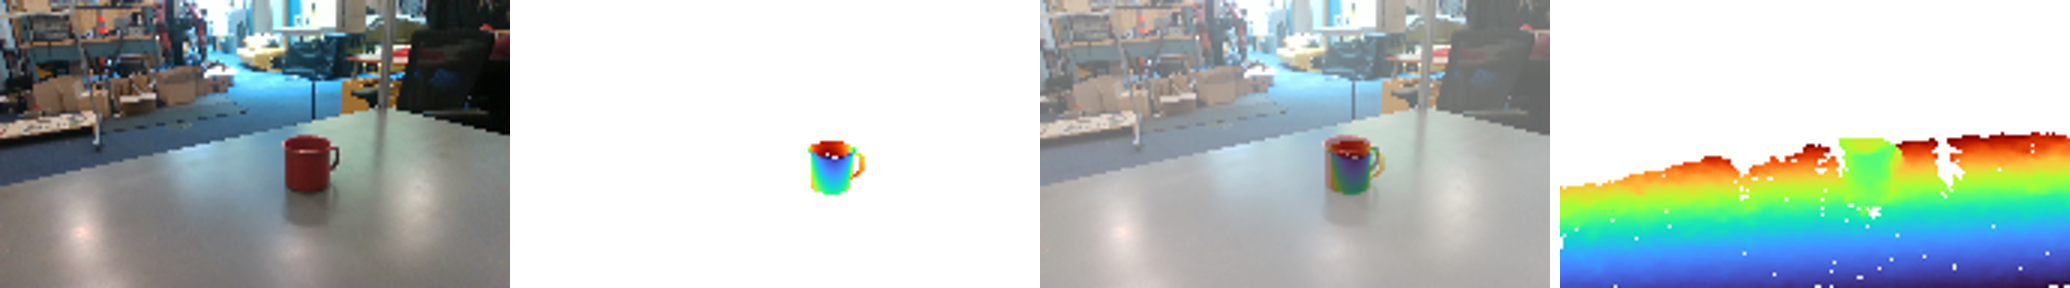

In [350]:
scaling_factor = 3.0
img = b.scale_image(
    b.get_depth_image(trace.get_retval()[1][...,2])
, scaling_factor)
rgb = b.scale_image(b.get_rgb_image(
    rgbd_scaled_down.rgb
),scaling_factor)
observed_depth = b.scale_image(b.get_depth_image(trace.get_retval()[0][...,2]), scaling_factor)

b.hstack_images([rgb, img, b.overlay_image(rgb, img, alpha=0.4), observed_depth])